In [1]:
import os, re
import pandas as pd
import numpy as np
import json

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 22

from csw_analysis import *

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
csw1_dict = {
  'csw121': "exp_0802063218",
  'csw122': "exp_0803092115",
  'csw1221': 'exp_0803140838',
  'csw130': 'exp_0803140838',
  'csw131': 'exp_0807064724',
  'csw132': 'exp_0807174758',
  'csw133': 'exp_0808090035',
  'csw140-bug': 'exp_0808160408',
  'csw141-bug': 'exp_0809054901',
  'csw8020u': 'exp_0808090035',
  'csw9010u': 'exp_0809072457',
  'csw9010cl': 'exp_0810053149',
  'csw9010cs': 'exp_0810083322',
  'csw1000cs': 'exp_0811103045',
}

csw2_dict = {  
  'csw1000u-single': 'exp_0919142232',
  'csw1000u': 'exp_0921104928',
  'csw1000cs':'exp_0923145239',
}


In [3]:
def apply_fillerq_thresh(subj_df_L,subj_tqdf_L,subj_fqdf_L,thresh):
  """ makes subj_df_Ls with only subjects above thresh
  """
  subj_df_L_new = []
  subj_tqdf_L_new = []
  subj_fqdf_L_new = []
  for subj_df,subj_tqdf,subj_fqdf in zip(subj_df_L,subj_tqdf_L,subj_fqdf_L):
    fillerQ_score = sum(subj_fqdf['correct_response'])/subj_fqdf.shape[0]
    if fillerQ_score < thresh: continue
    subj_df_L_new.append(subj_df)
    subj_tqdf_L_new.append(subj_tqdf)
    subj_fqdf_L_new.append(subj_fqdf)
  print(len(subj_fqdf_L_new),'above thresh')
  return subj_df_L_new, subj_tqdf_L_new, subj_fqdf_L_new

def get_all_subj_df_Ls(dataset_name,filler_thresh,dataset_dict=csw2_dict):
  # load sql
  exp_dir = "mturk_data/"+dataset_dict[dataset_name]
  sql_df = get_sql_df(exp_dir)
  # make subj_df
  subj_df_L = []
  for s in range(len(sql_df)):
    psiturk_dstr = sql_df['datastring'].iloc[s] 
    subj_df = make_subj_df(psiturk_dstr)
    subj_df_L.append(subj_df)
  # assign expr
  for subj_df in subj_df_L:
    assign_expr(subj_df,conditioned=True) # inplace
  # question dfs with question subtypes
  subj_qdf_L = [subj_df[subj_df['type']=='question'] for subj_df in subj_df_L]
  subj_fqdf_L = [subj_df[subj_df['qtype'] == 'fillerQ'] for subj_df in subj_df_L]
  subj_tqdf_L0 = [subj_df[subj_df['qtype'] == 'transQ'] for subj_df in subj_df_L]
  subj_tqdf_L = []
  # remove begin transition
  for subj_df in subj_tqdf_L0:
    subj_tqdf_L.append(subj_df[subj_df['fromnode']!='BEGIN'])
  # threshold filler questions
  subj_df_L,subj_tqdf_L,subj_fqdf_L = apply_fillerq_thresh(subj_df_L,
                                        subj_tqdf_L, subj_fqdf_L, filler_thresh)
  return subj_df_L,subj_tqdf_L,subj_fqdf_L


In [4]:
def get_common_denom(subj_score_L):
  """ given a list of lists, find smallest length"""
  len_L = [len(score) for score in subj_score_L]
  len_L.sort()
  min_len = len_L[0]
  return min_len
  
def get_common_denom_pair(tdfL1,tdfL2):
  """ takes two lists dataframes of transition questions
  returns two arrays with list of score arrays of same length
  """
  WINDOW = 130
  score_L1,expr = compute_scores(tdfL1,window=1)
  score_L2,expr = compute_scores(tdfL2,window=1)
  L = []
  L.extend(score_L1)
  L.extend(score_L2)
  T = get_common_denom(L)
  score_L1 = [np.mean(score[:T]) for score in score_L1]
  score_L2 = [np.mean(score[:T]) for score in score_L2]
  return score_L1,score_L2

# sliding window
def mov_avg(arr,window):
  """ calculates with sliding window average on array
  """
  L = []
  for idx in range(len(arr)-window):
    score = sum(arr[idx:idx+window])/window
    L.append(score)
  return np.array(L)

def compute_scores(subj_tqdf_L,window):
  """ given list of transition question dfs
  computes score and expr """
  subj_scores_L = []
  subj_expr_L = []
  for subj_tqdf in subj_tqdf_L:
    # compute and collect subj score and expr
    subj_score = mov_avg(subj_tqdf['correct_response'],window)
    subj_expr = mov_avg(subj_tqdf['expr_true_edge'],window)
    subj_scores_L.append(subj_score)
    subj_expr_L.append(subj_expr)
  return subj_scores_L, subj_expr_L

def group_mean_std_score(mov_avg_L):
  """ takes list of scores, returns group means
  after moving average has been applied
  get common smallest length and take group mean """
  # common denom
  min_len = get_common_denom(mov_avg_L)
  mov_avg_L = [subj_score[:min_len] for subj_score in mov_avg_L]
  # mean and stderr
  mean = np.mean(mov_avg_L,0)
  stderr = np.std(mov_avg_L,0) / np.sqrt(len(mov_avg_L))
  return mean,stderr



In [5]:
def full_plt_preproc(subj_tqdf_L,window):
  subj_scores_L, subj_expr_L = compute_scores(subj_tqdf_L,window)
  mean_score,std_score = group_mean_std_score(subj_scores_L)
  mean_expr,std_expr = group_mean_std_score(subj_expr_L)
  return mean_score,std_score,mean_expr,std_expr

def plt_group(ax,mean,std,c,lab,title=None,ylim=None):
  # score  
  xplt = np.linspace(0,100,len(mean))
  ax.plot(xplt,mean,label=lab,color=c,lw=4)
  ax.fill_between(xplt,mean-std, mean+std, alpha = 0.1,color=c)
  ax.grid(True)
  ax.set_ylim(0.48,.74)

In [12]:
subj_df_Lu, subj_tqdf_Lu, subj_fqdf_Lu = get_all_subj_df_Ls("csw1000u",0.8)

table name: csw1000_uncond
50 subjects
41 above thresh


In [13]:
subj_df_Lcs, subj_tqdf_Lcs, subj_fqdf_Lcs = get_all_subj_df_Ls("csw1000cs",0.8)

table name: csw1000_cond
27 subjects
20 above thresh


In [20]:
# load group mean data
window = 12
mean_score_u,std_score_u,mean_expr_u,std_expr_u = full_plt_preproc(subj_tqdf_Lu,window)
mean_score_cs,std_score_cs,mean_expr_cs,std_expr_cs = full_plt_preproc(subj_tqdf_Lcs,window)

No handles with labels found to put in legend.


Text(0.5,0.98,'csw summary')

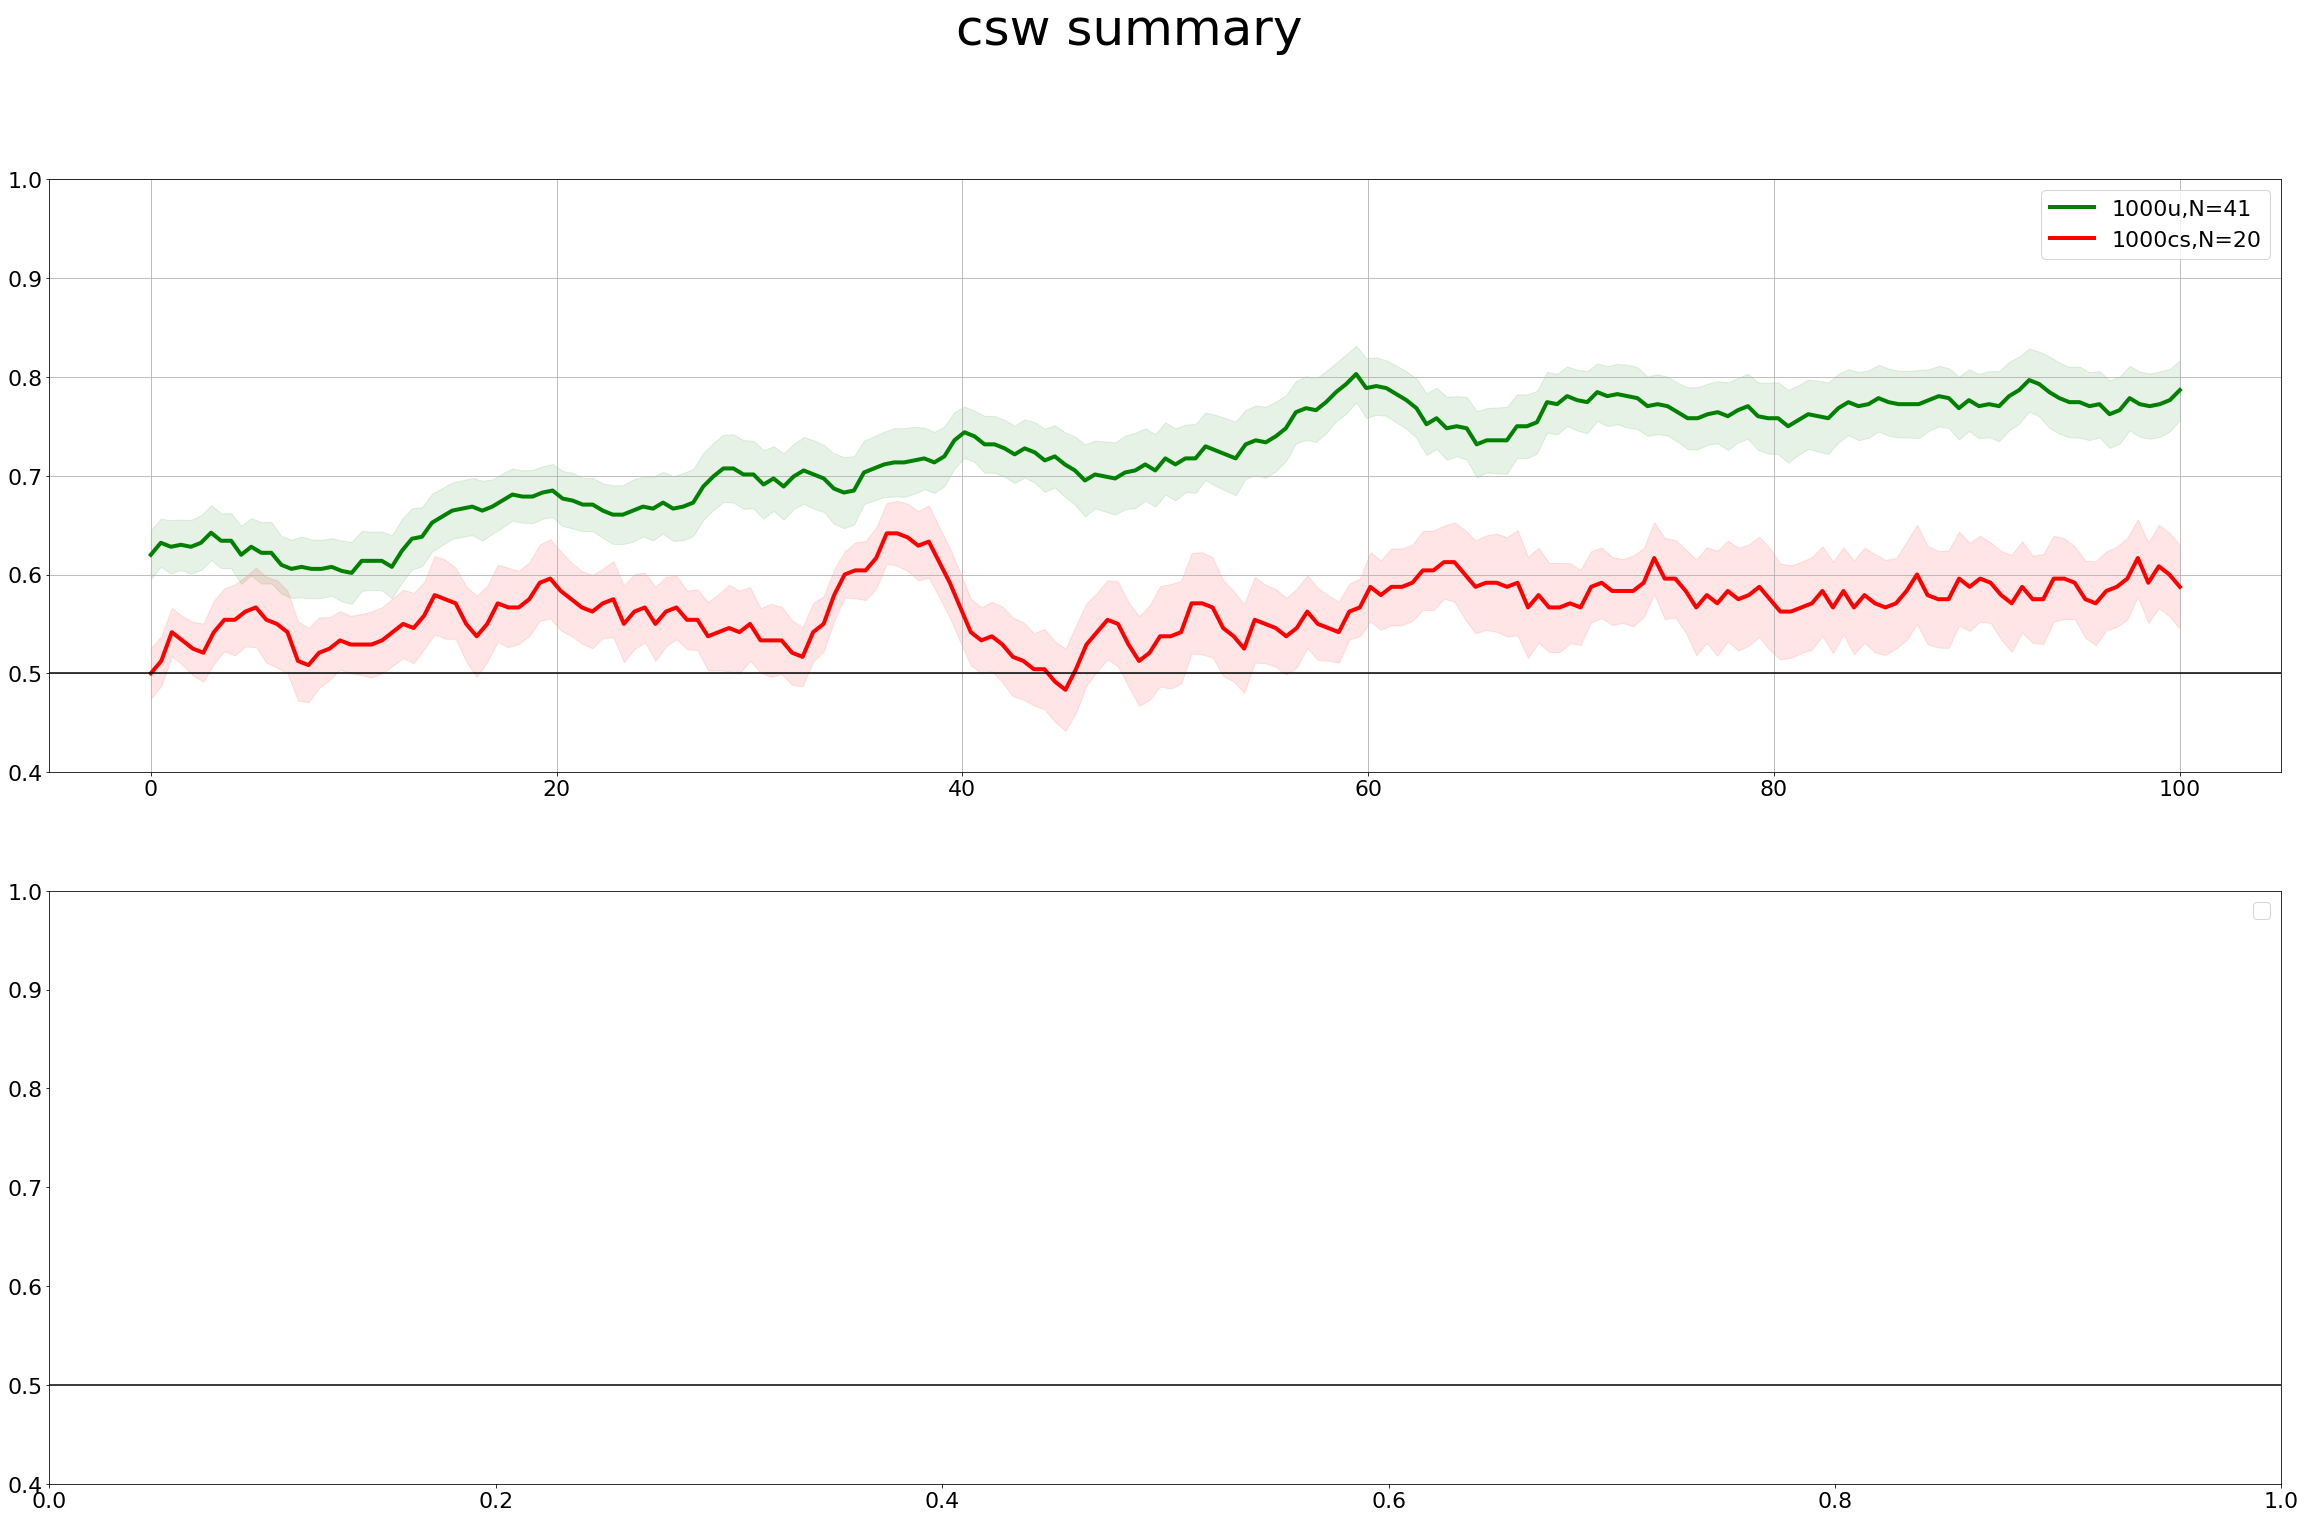

In [21]:
# plot
fig,axarr = plt.subplots(2,1,figsize=(40,8*3));axarr = axarr.reshape(-1)


plt_group(axarr[0],mean_score_u,std_score_u,c='green',lab='1000u,N=%i'%len(subj_tqdf_Lu))
plt_group(axarr[0],mean_score_cs,std_score_cs,c='red',lab='1000cs,N=%i'%len(subj_tqdf_Lcs))


# axarr[0].set_title('8020 vs 9010 unconditioned')
# axarr[1].set_title('9010 vs 1000 conditioned subject')

for ax in axarr:
  ax.set_ylim(0.4,1)
  ax.axhline(0.5,color='black')
  ax.legend()
  
plt.suptitle('csw summary',size=50)
# plt.savefig('figures/summary0814')
